In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import joblib

In [2]:
# Load the data
data = pd.read_csv('../dataset/node4_data.csv')
data['needs_charge'] = np.where(data['charge'] <= 50, 1, 0)

DATA CLEANING

In [3]:
# Data Cleaning
data = pd.get_dummies(data, columns=['weather', 'traffic', 'road_gradient', 'emergency', 'car_status'])
data = data.drop_duplicates()
data = data.select_dtypes(include=[float, int])
# Check the column names
print(data.columns)

Index(['current_speed', 'battery_capacity', 'charge', 'consumption',
       'location', 'distance_covered', 'battery_life',
       'distance_to_charging_point', 'emergency_duration', 'needs_charge'],
      dtype='object')


Feature Selection

In [4]:
# Feature Selection
features = ['current_speed', 'battery_capacity', 'charge', 'consumption', 'distance_covered', 'battery_life', 'distance_to_charging_point']
features += [col for col in data if 'weather_' in col]
features += [col for col in data if 'traffic_' in col]
features += [col for col in data if 'road_gradient_' in col]
features += [col for col in data if 'emergency_' in col]
features += [col for col in data if 'car_status_' in col]

X = data[features]
y = data['needs_charge']

print(X.head())

   current_speed  battery_capacity     charge  consumption  distance_covered  \
0             43                45  87.647841         0.11          1.466667   
1             34                45  87.565395         0.11          2.183333   
2             19                45  87.514378         0.11          2.750000   
3             20                45  87.499070         0.11          3.066667   
4             97                45  87.482031         0.11          3.400000   

   battery_life  distance_to_charging_point  emergency_duration  
0        98.999                   35.533333                   0  
1        98.998                   34.816667                   0  
2        98.997                   34.250000                   0  
3        98.996                   33.933333                   0  
4        98.995                   33.600000                   0  


In [5]:
# Create a copy of the DataFrame slice
X = X.copy()

# Display columns which contain 'inf' or '-inf' values
inf_columns = X.columns[X.isin([float('inf'), -float('inf')]).any()].tolist()
print(f"Columns with inf values: {inf_columns}")

# Replace 'inf' and '-inf' values in those columns with NaN
for col in inf_columns:
    X[col].replace([float('inf'), -float('inf')], float('nan'), inplace=True)

for col in inf_columns:
    X[col].fillna(X[col].mean(), inplace=True)

Columns with inf values: ['distance_to_charging_point']


In [6]:
# Initialize the model with higher max_iter
model = LogisticRegression(max_iter=1000)

# Initialize RFE
rfe = RFE(model, n_features_to_select=10)

# Fit RFE
fit = rfe.fit(X, y)

# Get the selected features
selected_features = X.columns[fit.support_]
print("Selected Features: ", selected_features)

Selected Features:  Index(['current_speed', 'battery_capacity', 'charge', 'consumption',
       'distance_covered', 'battery_life', 'distance_to_charging_point',
       'emergency_duration'],
      dtype='object')


In [7]:
print(data['charge'].describe())
print(data['needs_charge'].value_counts())

count    25268.000000
mean        48.051855
std         19.800796
min          0.000000
25%         32.204271
50%         48.083605
75%         61.302663
max        100.000000
Name: charge, dtype: float64
1    13553
0    11715
Name: needs_charge, dtype: int64


In [8]:
print(data['needs_charge'].value_counts())

1    13553
0    11715
Name: needs_charge, dtype: int64


In [9]:
# # Data Splitting
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Data Splitting using selected features
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

In [10]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [11]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

Data Visualization

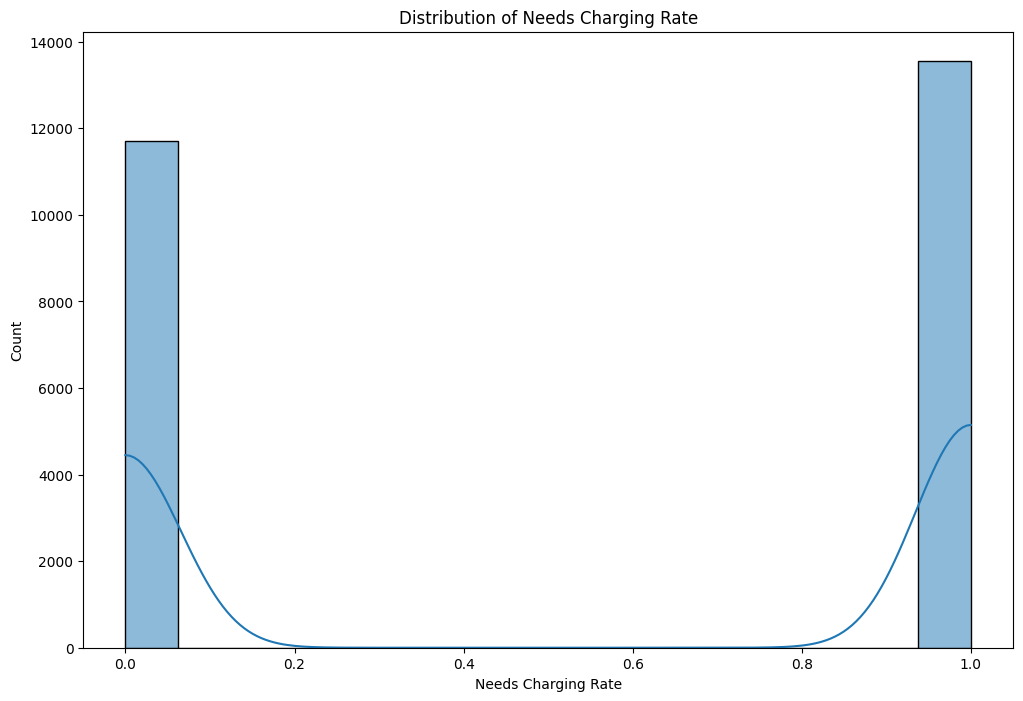

In [12]:
# Distribution of the target variable
plt.figure(figsize=(12,8))
sns.histplot(data['needs_charge'], kde=True)
plt.title('Distribution of Needs Charging Rate')
plt.xlabel('Needs Charging Rate')
plt.ylabel('Count')
plt.show()

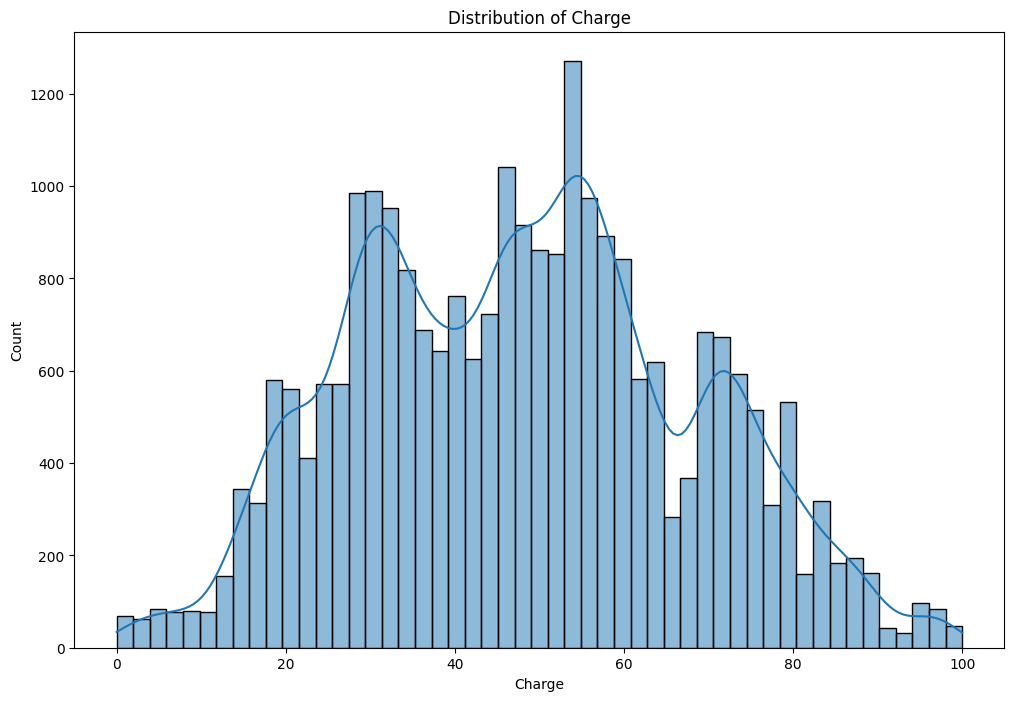

In [13]:
# plot the distribution 
plt.figure(figsize=(12,8))
sns.histplot(data['charge'], kde=True)
plt.title('Distribution of Charge')
plt.xlabel('Charge')
plt.ylabel('Count')
plt.show()


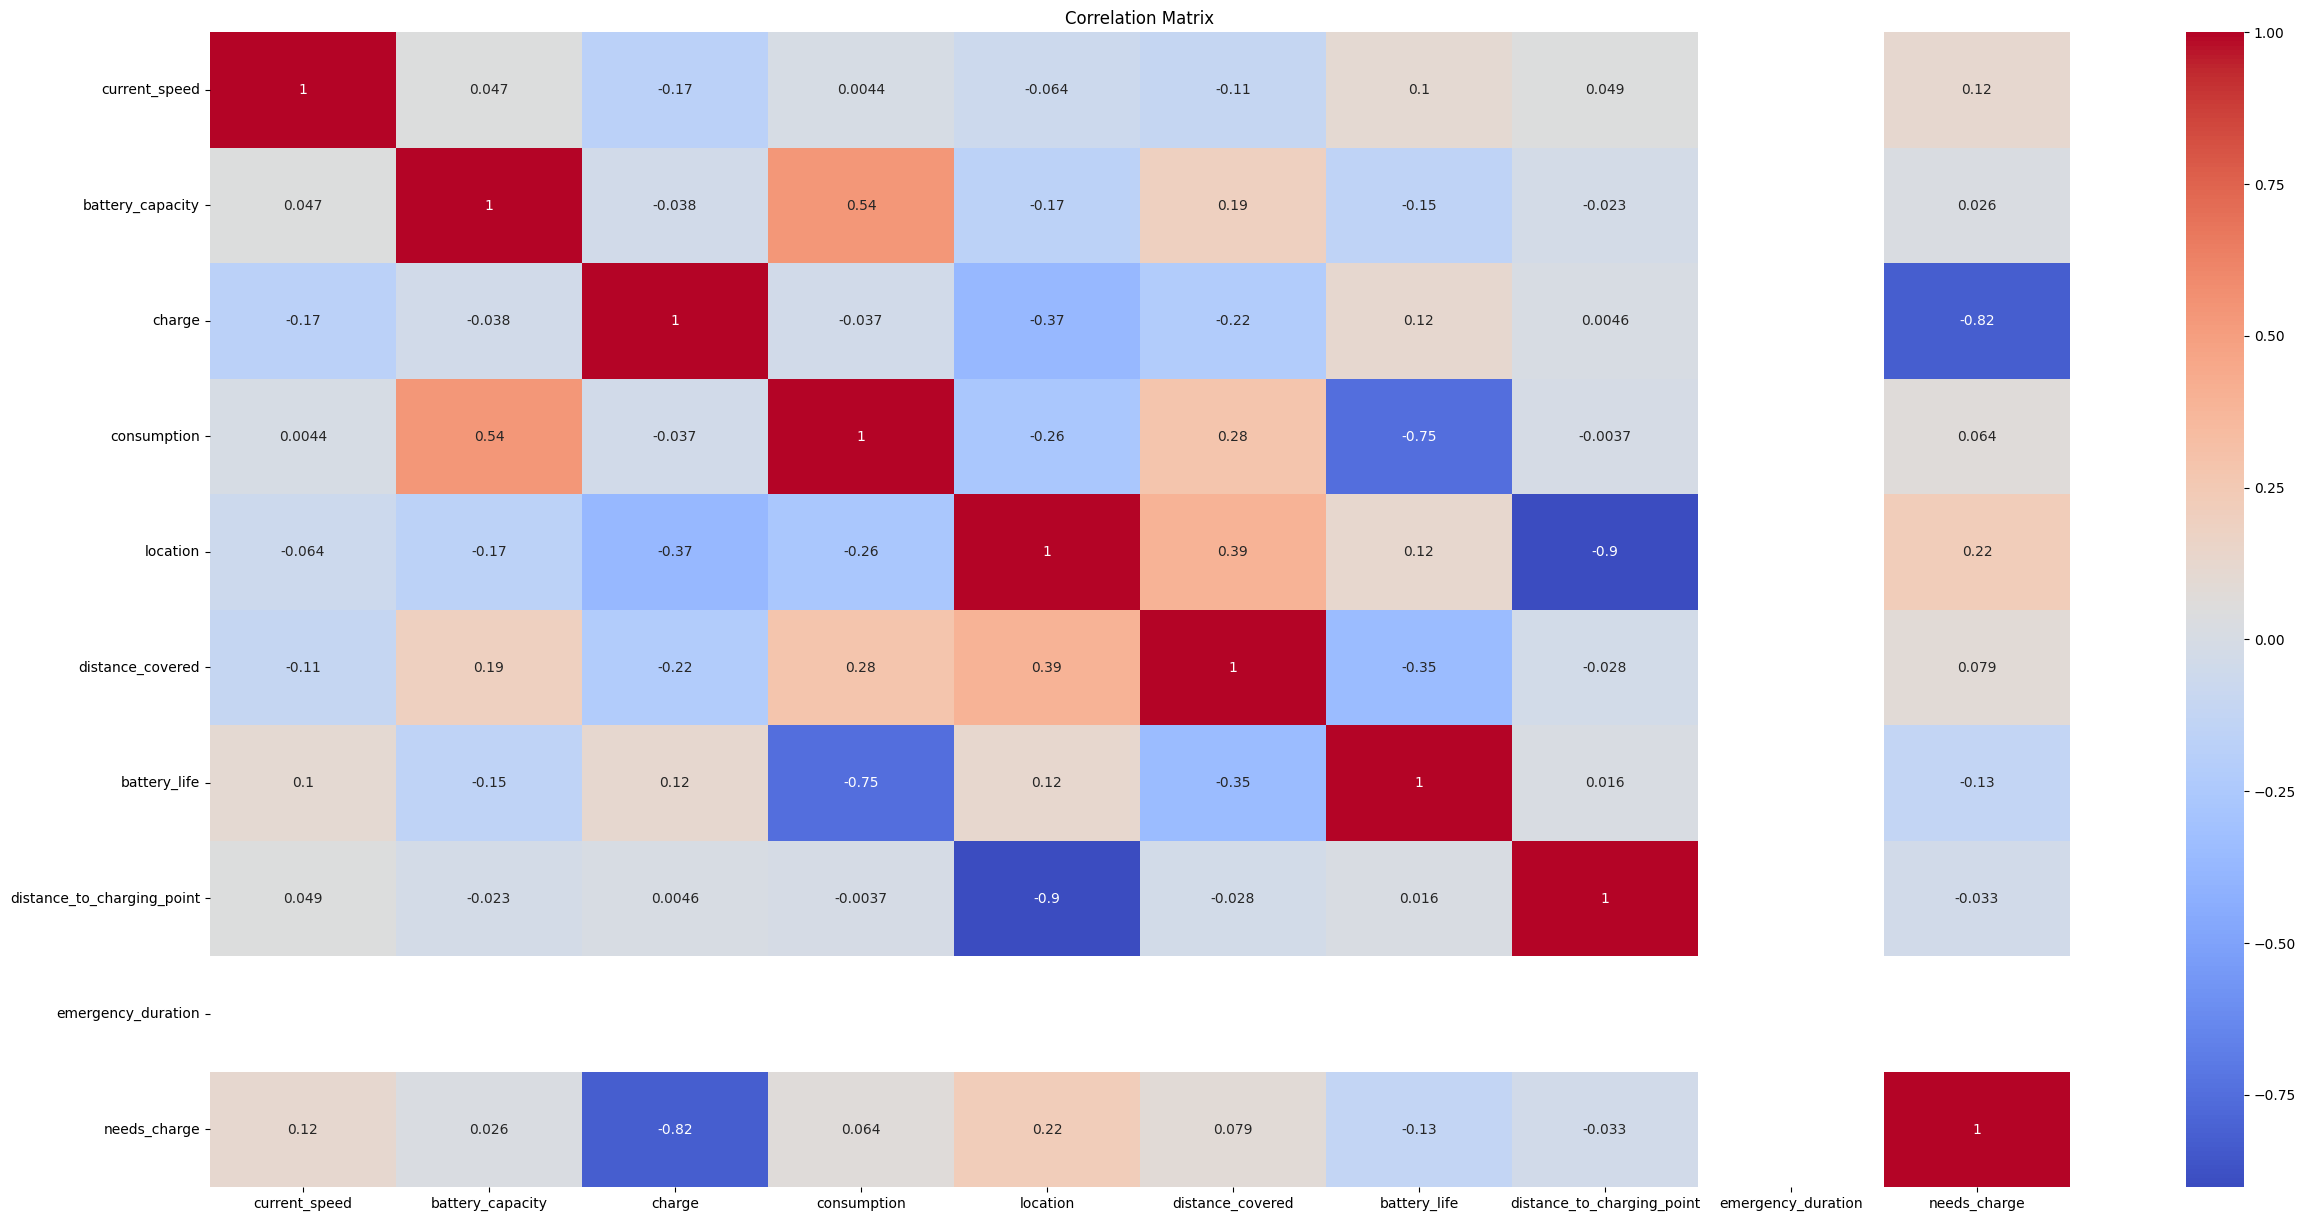

In [14]:
## Correlation Analysis
correlation_matrix = data.corr()
plt.figure(figsize=(30,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

/home/maith/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


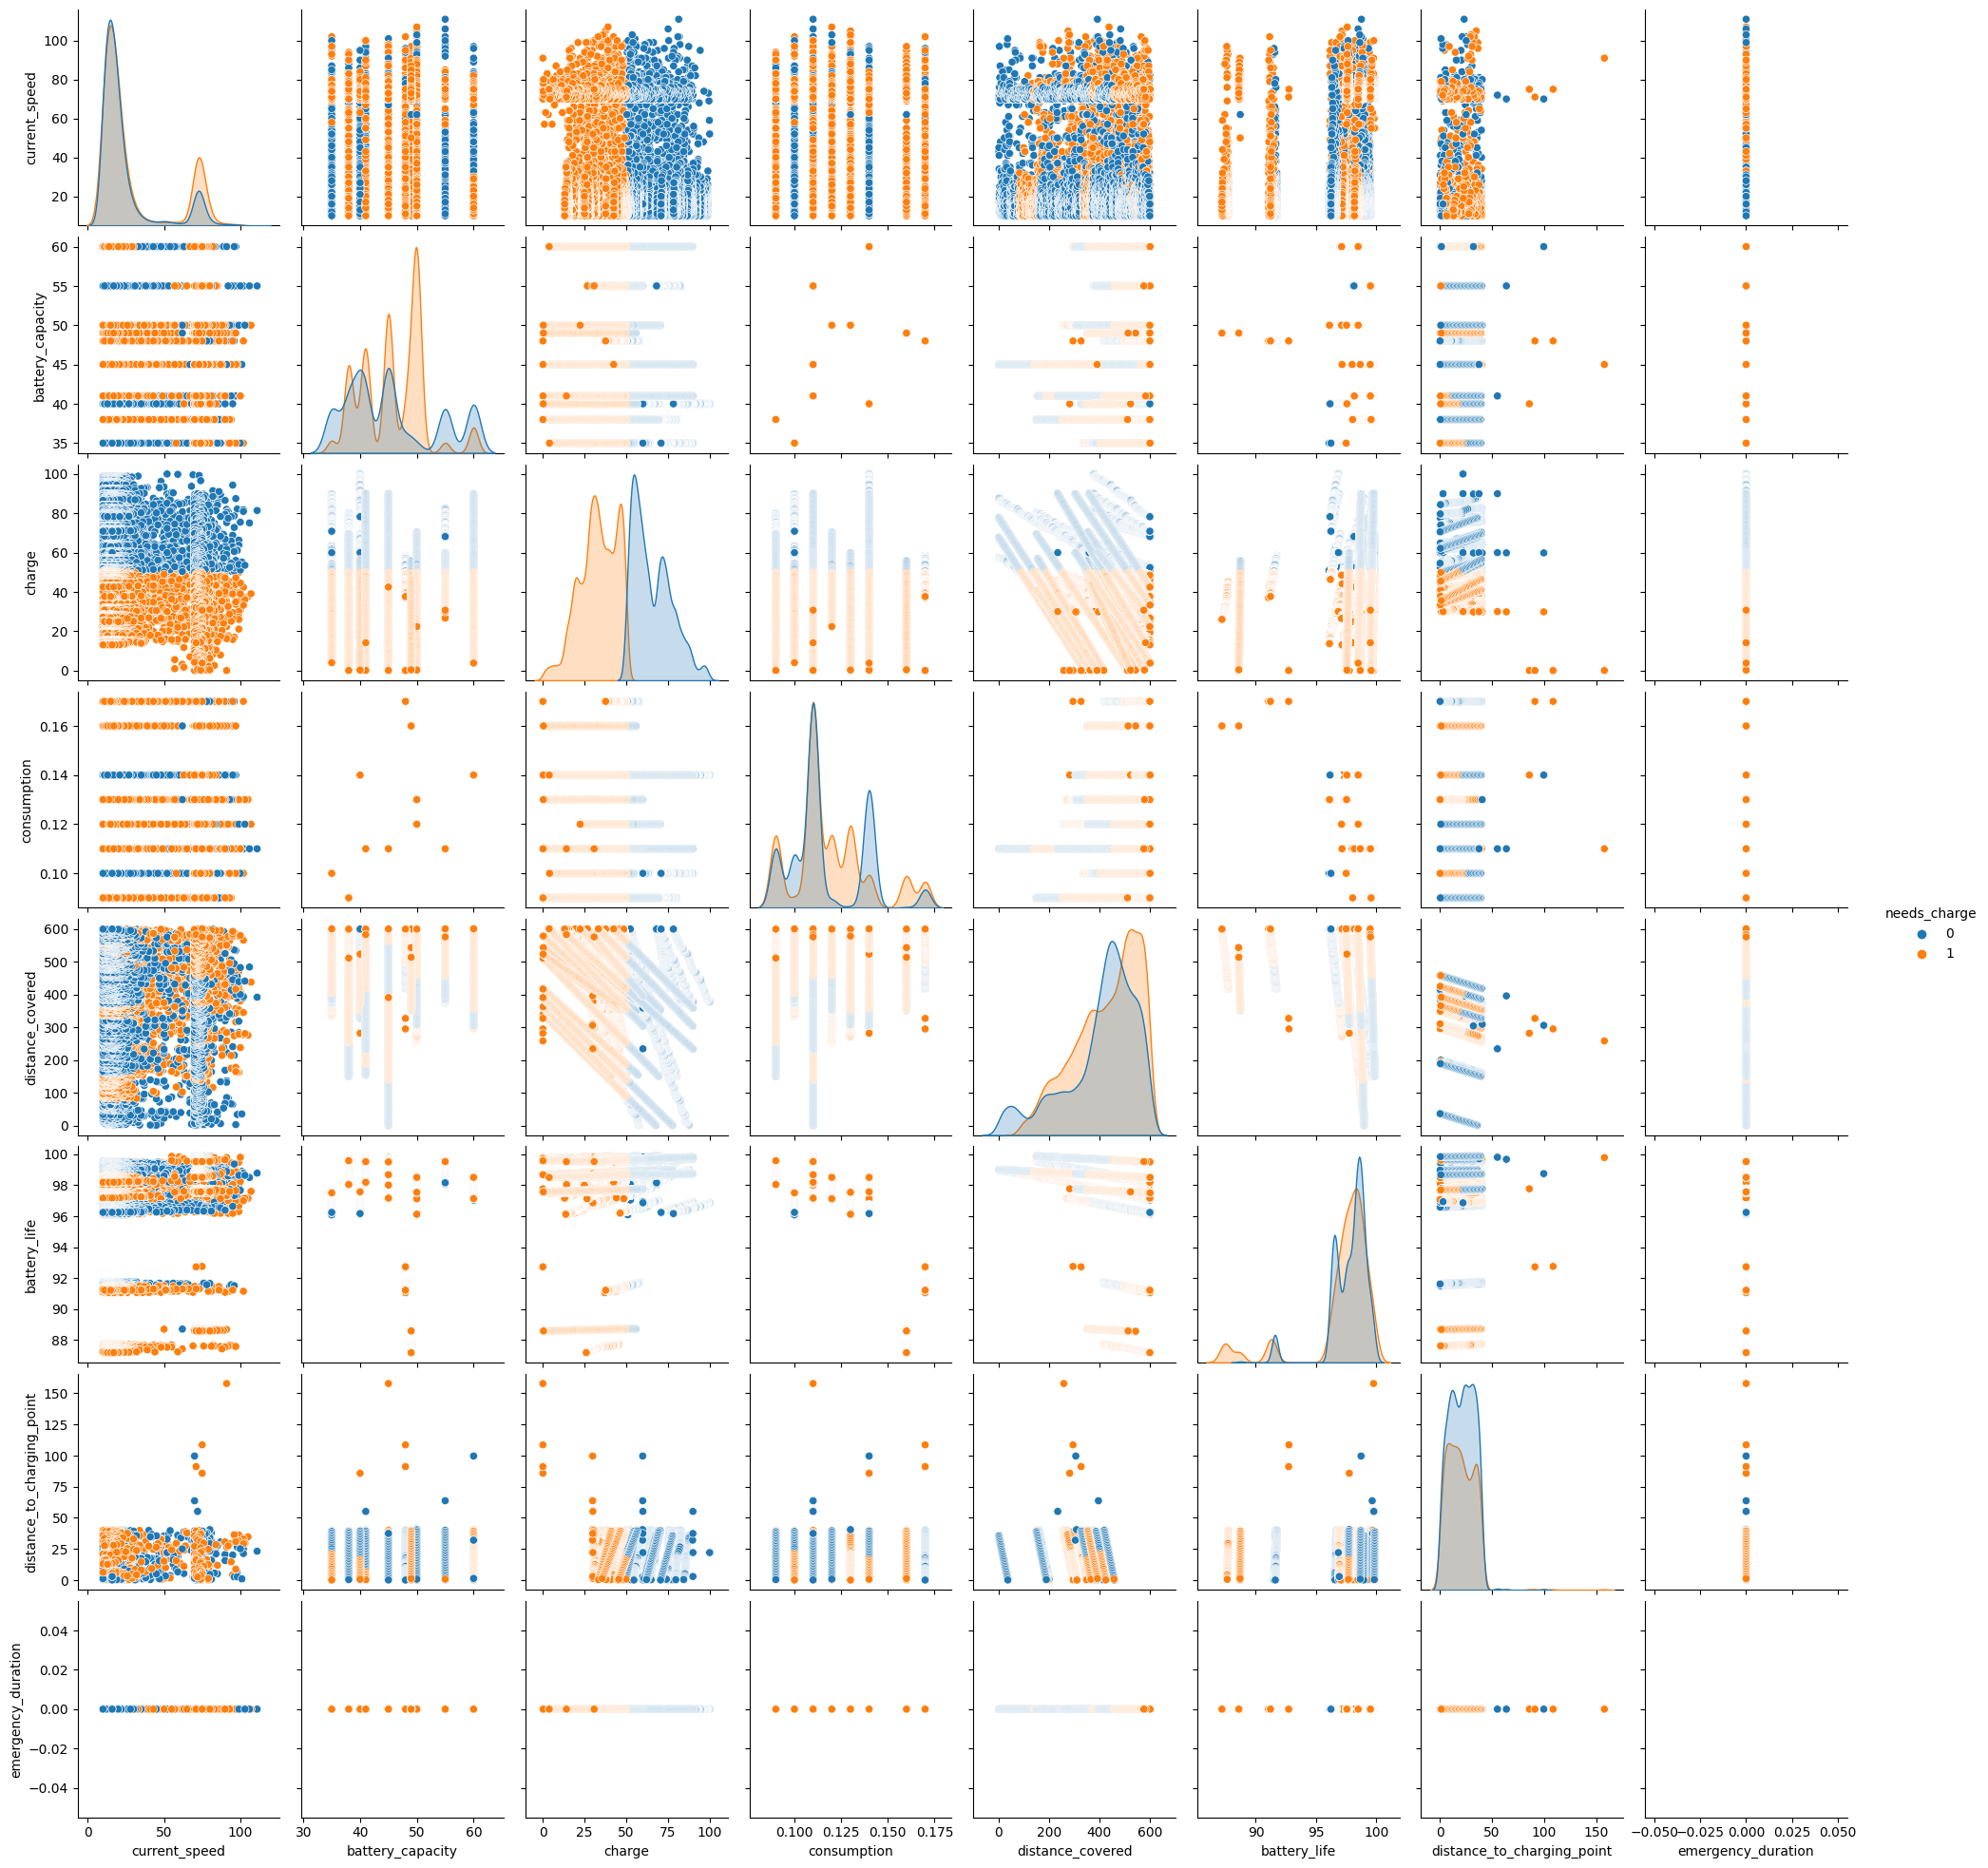

In [15]:
# Pairplot of the features and target variable
sns.pairplot(data[features + ['needs_charge']], hue='needs_charge')
plt.show()

/home/maith/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


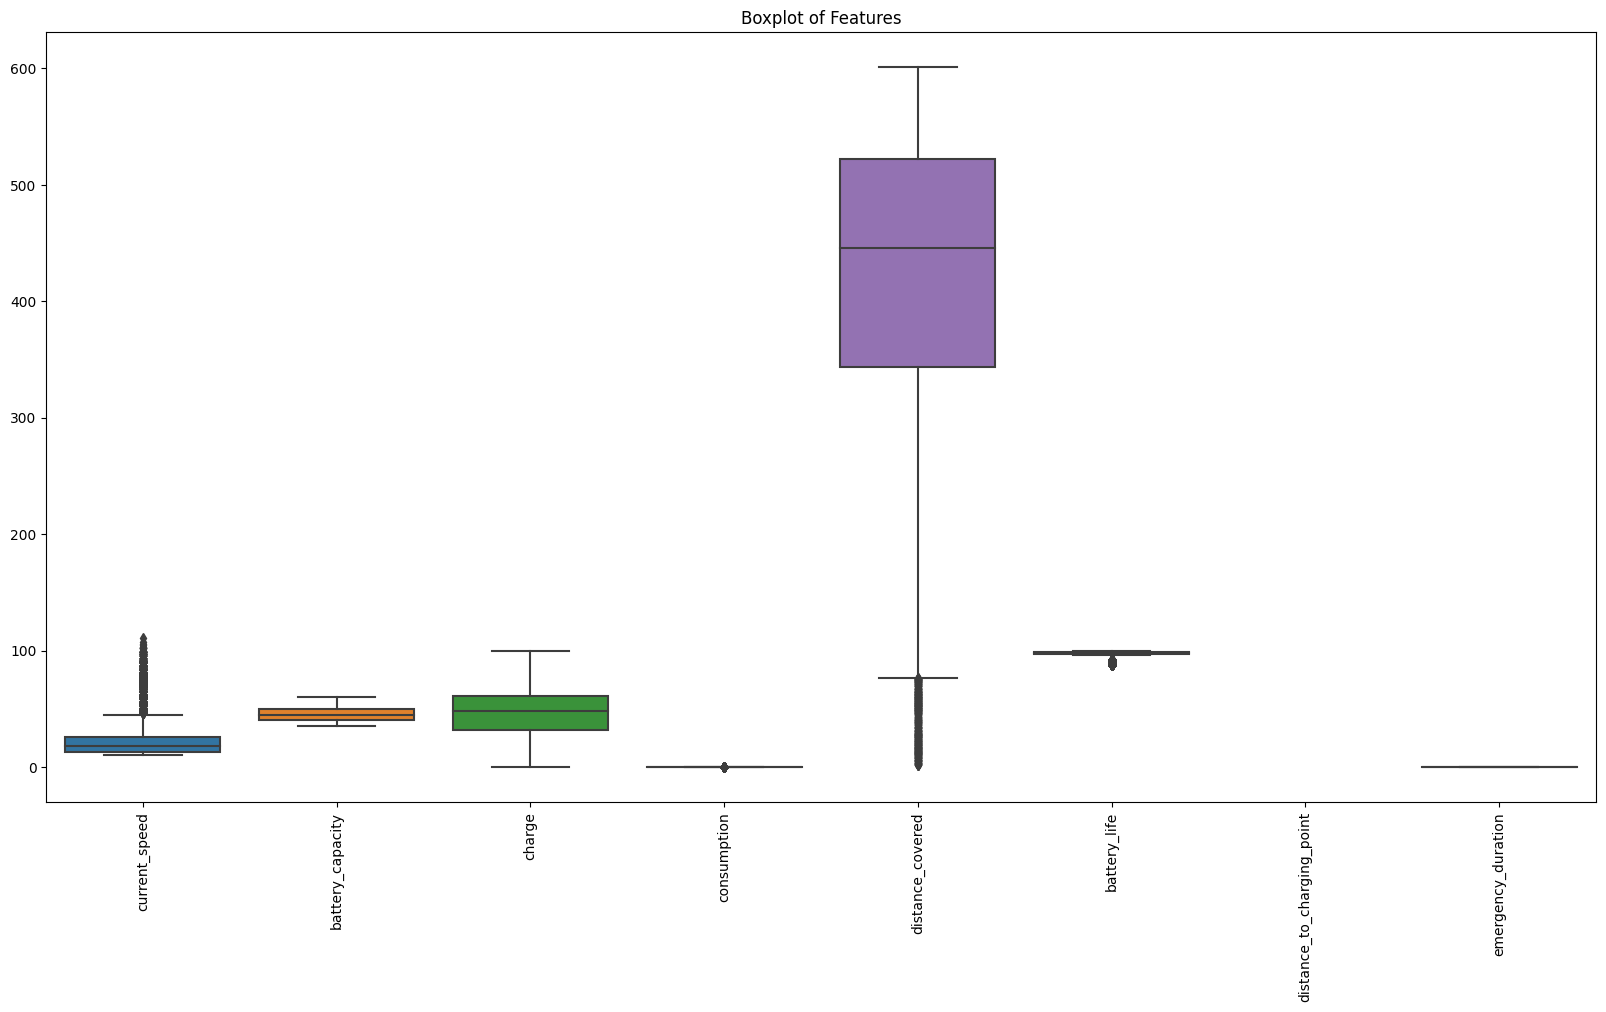

In [16]:
# Boxplots for each feature
plt.figure(figsize=(20, 10))
sns.boxplot(data=data[features])
plt.title('Boxplot of Features')
plt.xticks(rotation=90)
plt.show()

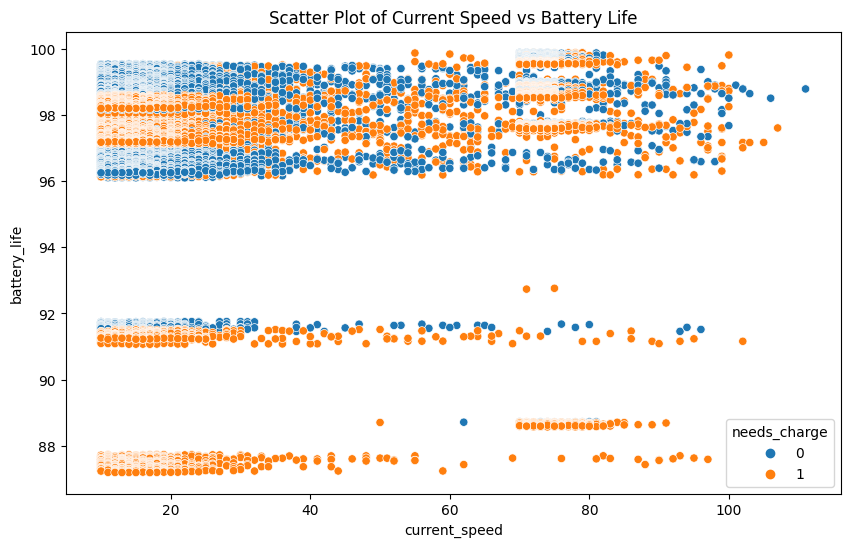

In [17]:
# Scatter plots
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='current_speed', y='battery_life', hue='needs_charge')
plt.title('Scatter Plot of Current Speed vs Battery Life')
plt.show()

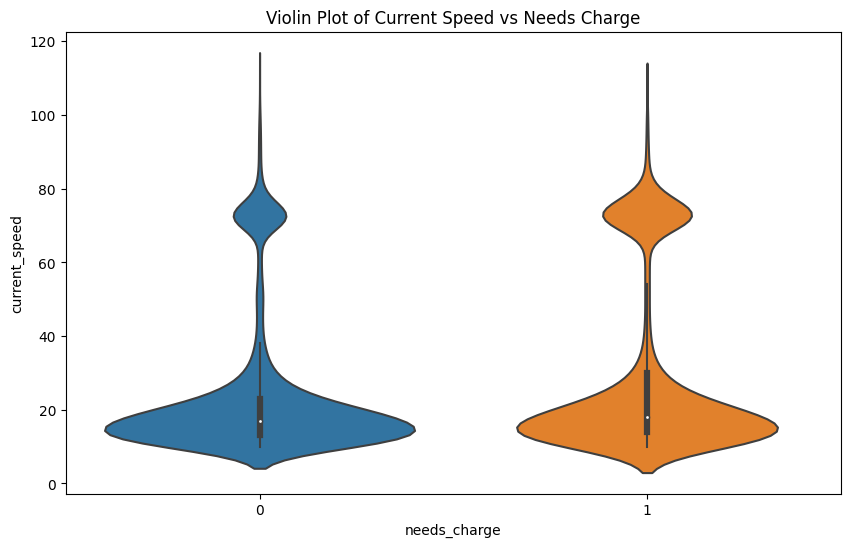

In [18]:
# Violin plots
plt.figure(figsize=(10, 6))
sns.violinplot(x=data['needs_charge'], y=data['current_speed'])
plt.title('Violin Plot of Current Speed vs Needs Charge')
plt.show()

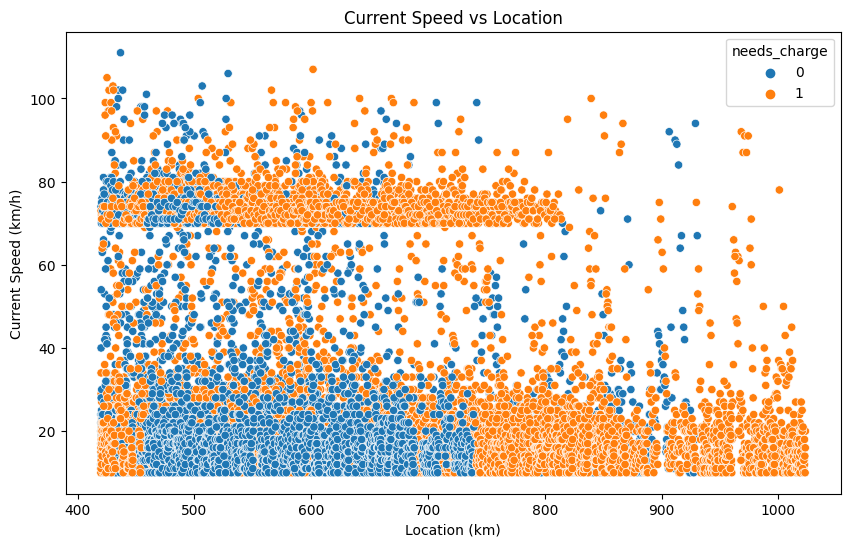

In [19]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='location', y='current_speed', hue='needs_charge')
plt.title('Current Speed vs Location')
plt.xlabel('Location (km)')
plt.ylabel('Current Speed (km/h)')
plt.show()

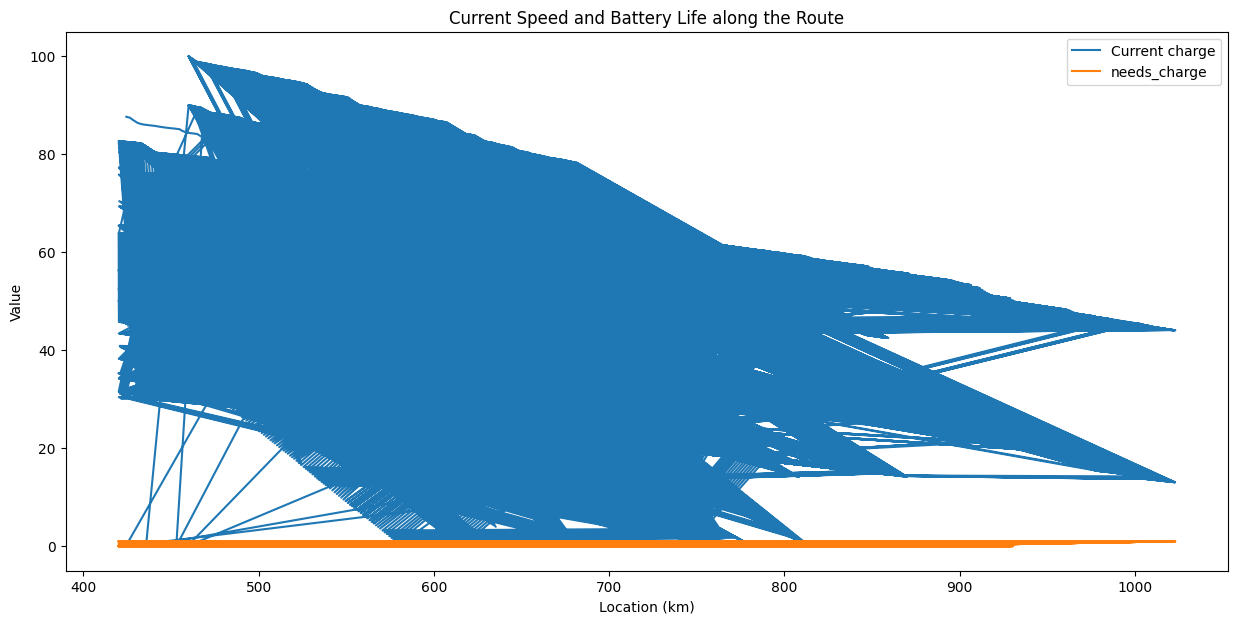

In [20]:
plt.figure(figsize=(15, 7))
plt.plot(data['location'], data['charge'], label='Current charge')
plt.plot(data['location'], data['needs_charge'], label='needs_charge')
plt.title('Current Speed and Battery Life along the Route')
plt.xlabel('Location (km)')
plt.ylabel('Value')
plt.legend()
plt.show()

In [21]:
# Support Vector Machines (SVM)
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Initialize the model
model = SVC()

# Fit the model
model.fit(X_train_scaled, y_train_resampled)

# Make predictions
predictions = model.predict(X_train_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_train_resampled, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(y_train_resampled, predictions, zero_division=1)
print(report)

# save the model
joblib.dump(model, 'svm_model_node4.pkl')
joblib.dump(scaler, 'svc_scaler_node4.pkl')


Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9452
           1       1.00      0.99      0.99      9452

    accuracy                           0.99     18904
   macro avg       0.99      0.99      0.99     18904
weighted avg       0.99      0.99      0.99     18904



['svc_scaler_node4.pkl']

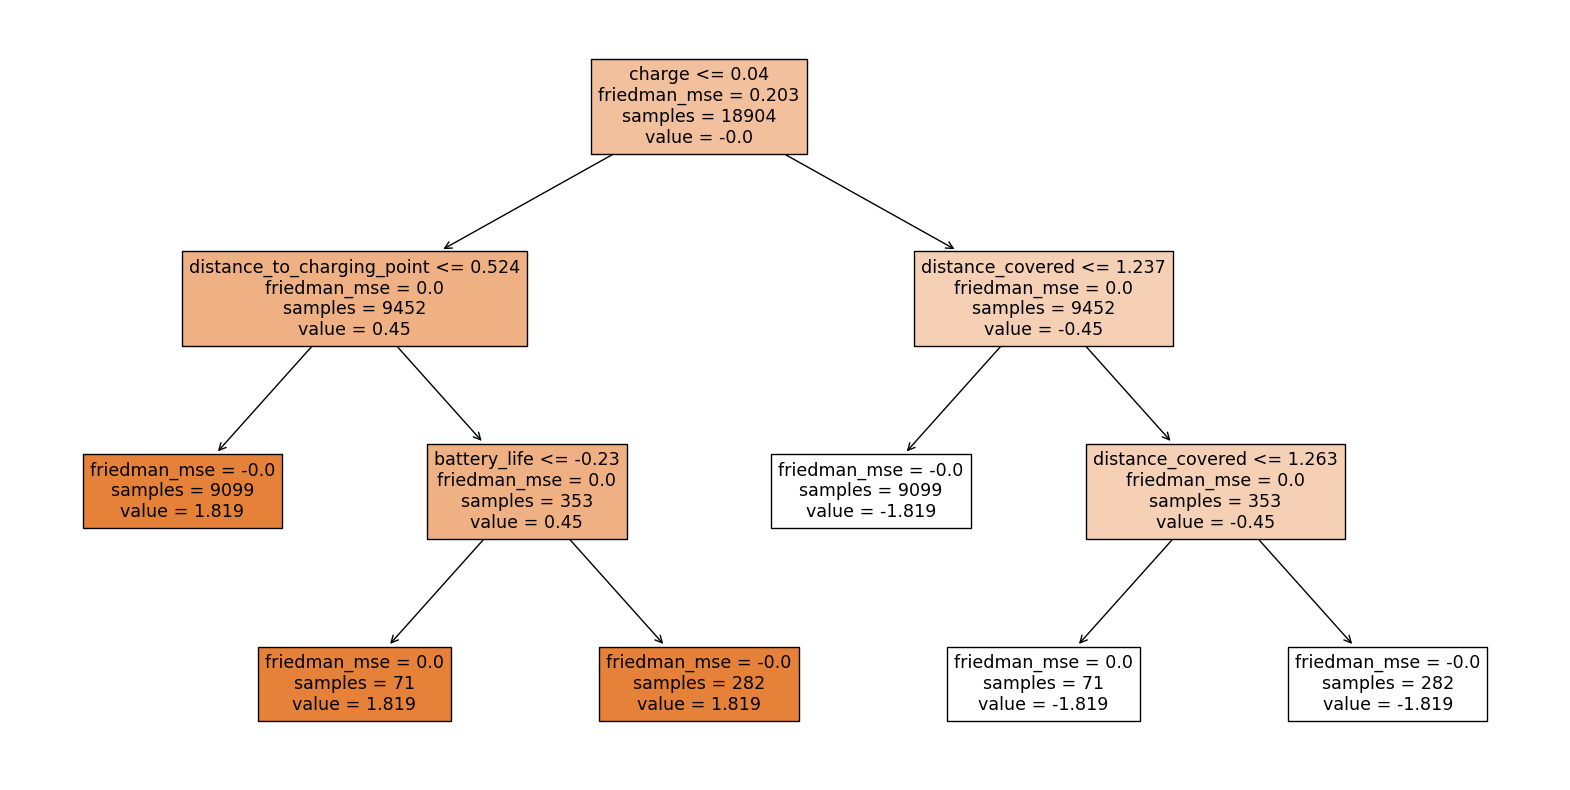

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9452
           1       1.00      1.00      1.00      9452

    accuracy                           1.00     18904
   macro avg       1.00      1.00      1.00     18904
weighted avg       1.00      1.00      1.00     18904



['gbm_scaler_node4.pkl']

In [22]:
# Gradient Boosting Machinesv (GBM)
from sklearn.tree import plot_tree

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Initialize the model
model = GradientBoostingClassifier()

# Fit the model
model.fit(X_train_scaled, y_train_resampled)

# Get one of the trees from the ensemble of trees
single_tree = model.estimators_[1, 0]

# Convert the pandas Index object to a list
feature_names_list = X.columns.tolist()

# Visualize this tree
plt.figure(figsize=(20, 10))
plot_tree(single_tree, feature_names=feature_names_list, filled=True)
plt.show()

# Make predictions
predictions = model.predict(X_train_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_train_resampled, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(y_train_resampled, predictions, zero_division=1)
print(report)

# save the model
joblib.dump(model, 'gbm_model_node4.pkl')
joblib.dump(scaler, 'gbm_scaler_node4.pkl')

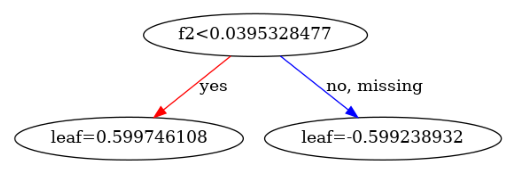

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9452
           1       1.00      1.00      1.00      9452

    accuracy                           1.00     18904
   macro avg       1.00      1.00      1.00     18904
weighted avg       1.00      1.00      1.00     18904



['xgb_scaler_node4.pkl']

In [23]:
# XGBoost (XGB)
from xgboost import plot_tree

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Initialize the model
model = XGBClassifier()

# Fit the model
model.fit(X_train_scaled, y_train_resampled)

# visualize
plot_tree(model)
plt.show()

# Make predictions
predictions = model.predict(X_train_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_train_resampled, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(y_train_resampled, predictions, zero_division=1)
print(report)

# save the model
joblib.dump(model, 'xgb_model_node4.pkl')
joblib.dump(scaler, 'xgb_scaler_node4.pkl')

In [24]:
# CatBoost (CB)
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Initialize the model
model = CatBoostClassifier(verbose=False)

# Fit the model
model.fit(X_train_scaled, y_train_resampled)

# Make predictions
predictions = model.predict(X_train_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_train_resampled, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(y_train_resampled, predictions, zero_division=1)
print(report)

# save the model
joblib.dump(model, 'cb_model_node4.pkl')
joblib.dump(scaler, 'cb_scaler_node4.pkl')

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9452
           1       1.00      1.00      1.00      9452

    accuracy                           1.00     18904
   macro avg       1.00      1.00      1.00     18904
weighted avg       1.00      1.00      1.00     18904



['cb_scaler_node4.pkl']

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9452
           1       1.00      1.00      1.00      9452

    accuracy                           1.00     18904
   macro avg       1.00      1.00      1.00     18904
weighted avg       1.00      1.00      1.00     18904



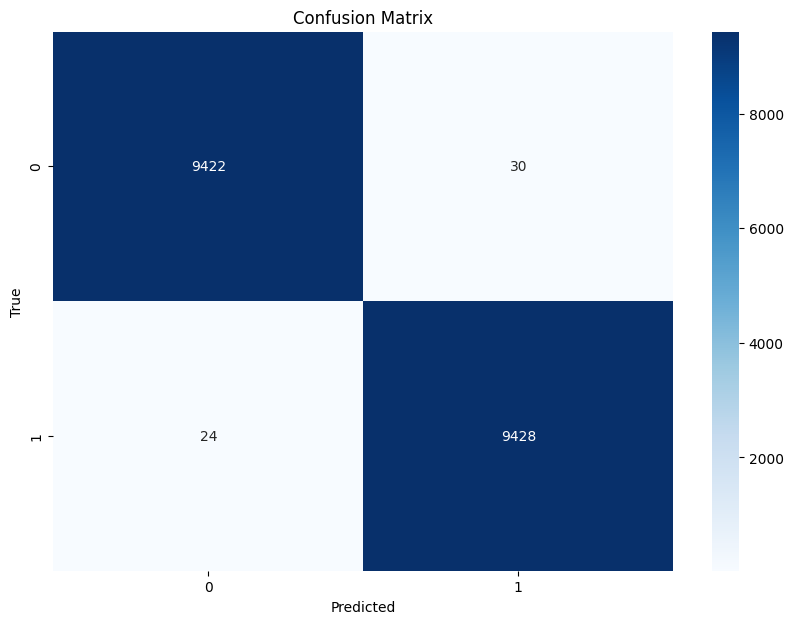

['knn_scaler_node4.pkl']

In [25]:
# K-Nearest Neighbors (KNN)
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Initialize the model
model = KNeighborsClassifier()

# Fit the model
model.fit(X_train_scaled, y_train_resampled)

# Make predictions
predictions = model.predict(X_train_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_train_resampled, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(y_train_resampled, predictions, zero_division=1)
print(report)

# Plotting the confusion matrix using seaborn
y_pred = model.predict(X_train_scaled)
cm = confusion_matrix(y_train_resampled, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# save the model
joblib.dump(model, 'knn_model_node4.pkl')
joblib.dump(scaler, 'knn_scaler_node4.pkl')

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9452
           1       1.00      1.00      1.00      9452

    accuracy                           1.00     18904
   macro avg       1.00      1.00      1.00     18904
weighted avg       1.00      1.00      1.00     18904



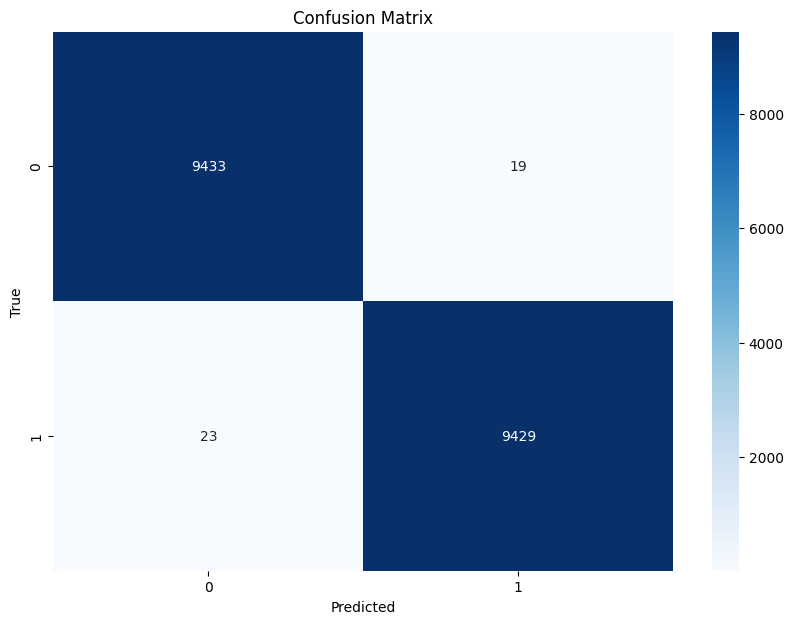

['logisticReg_scaler_node4.pkl']

In [26]:
# Logistic Regression
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Initialize the model
model = LogisticRegression()

# Fit the model
model.fit(X_train_scaled, y_train_resampled)

# Make predictions
predictions = model.predict(X_train_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_train_resampled, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(y_train_resampled, predictions, zero_division=1)
print(report)

# Plotting the confusion matrix using seaborn
y_pred = model.predict(X_train_scaled)
cm = confusion_matrix(y_train_resampled, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# save the model
joblib.dump(model, 'logisticReg_model_node4.pkl')
joblib.dump(scaler, 'logisticReg_scaler_node4.pkl')

Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      9452
           1       0.95      0.91      0.93      9452

    accuracy                           0.93     18904
   macro avg       0.93      0.93      0.93     18904
weighted avg       0.93      0.93      0.93     18904



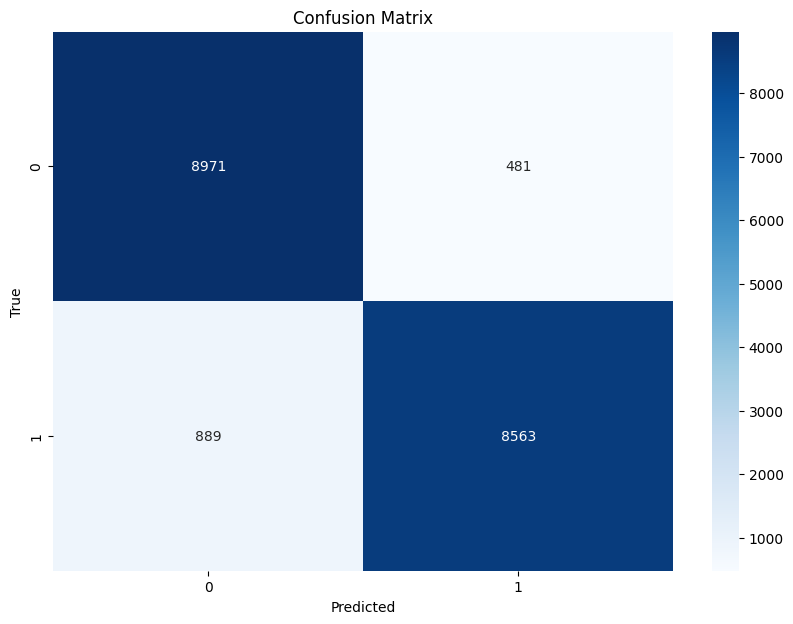

['gnb_scaler_node4.pkl']

In [27]:
# Gaussian Naive Bayes
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Initialize the model
model = GaussianNB()

# Fit the model
model.fit(X_train_scaled, y_train_resampled)

# Make predictions
predictions = model.predict(X_train_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_train_resampled, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(y_train_resampled, predictions, zero_division=1)
print(report)

# Plotting the confusion matrix using seaborn
y_pred = model.predict(X_train_scaled)
cm = confusion_matrix(y_train_resampled, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# save the model
joblib.dump(model, 'gnb_model_node4.pkl')
joblib.dump(scaler, 'gnb_scaler_node4.pkl')

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9452
           1       1.00      1.00      1.00      9452

    accuracy                           1.00     18904
   macro avg       1.00      1.00      1.00     18904
weighted avg       1.00      1.00      1.00     18904



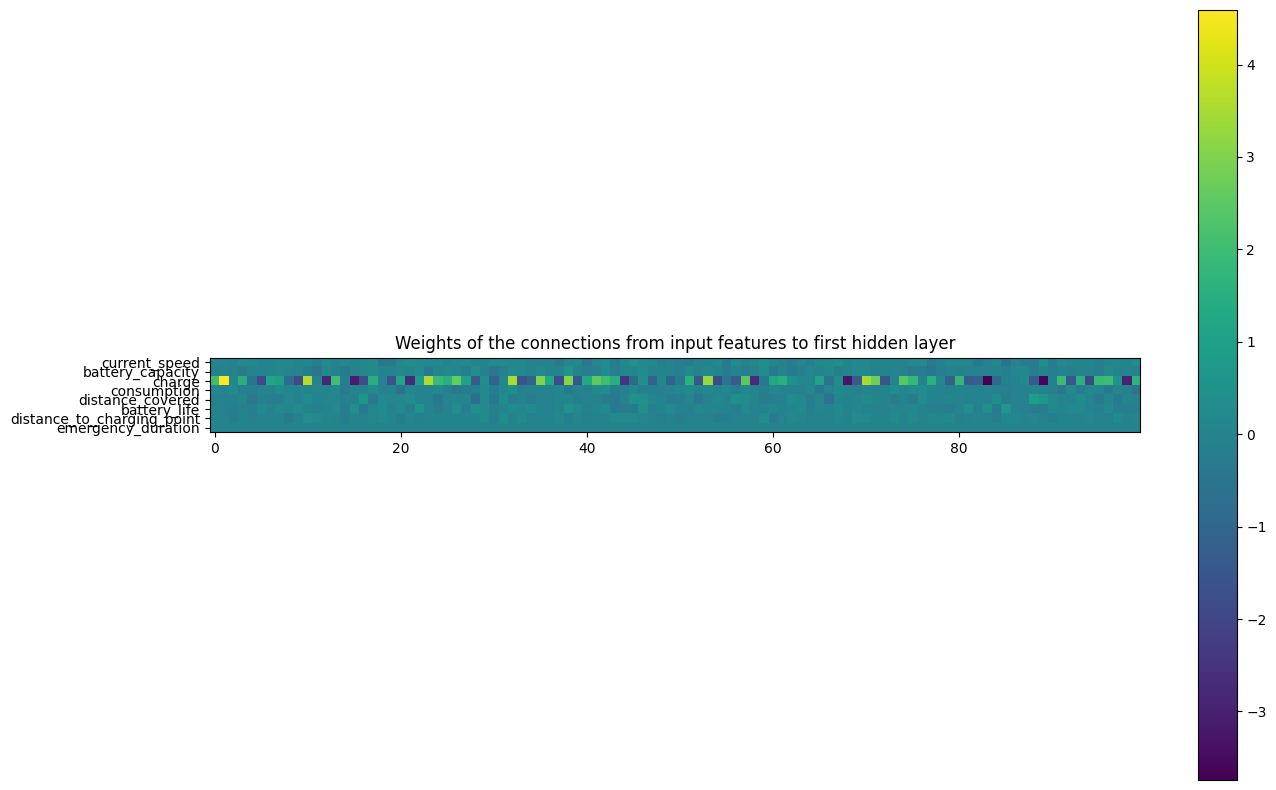

['tdl_scaler_node4.pkl']

In [28]:
# Temporal Difference Learning (TD-Learning)
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Initialize the model
model = MLPClassifier(max_iter=1000)

# Fit the model
model.fit(X_train_scaled, y_train_resampled)

# Make predictions
predictions = model.predict(X_train_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_train_resampled, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(y_train_resampled, predictions, zero_division=1)
print(report)

# Assuming model is your trained MLPClassifier
weights = model.coefs_[0]

# Visualizing weights using a heatmap
plt.figure(figsize=(15, 10))
plt.imshow(weights, interpolation='none', cmap='viridis')
plt.yticks(range(X_train_scaled.shape[1]), X.columns)
plt.colorbar()
plt.title('Weights of the connections from input features to first hidden layer')
plt.show()

# save the model
joblib.dump(model, 'tdl_model_node4.pkl')
joblib.dump(scaler, 'tdl_scaler_node4.pkl')

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9452
           1       1.00      1.00      1.00      9452

    accuracy                           1.00     18904
   macro avg       1.00      1.00      1.00     18904
weighted avg       1.00      1.00      1.00     18904



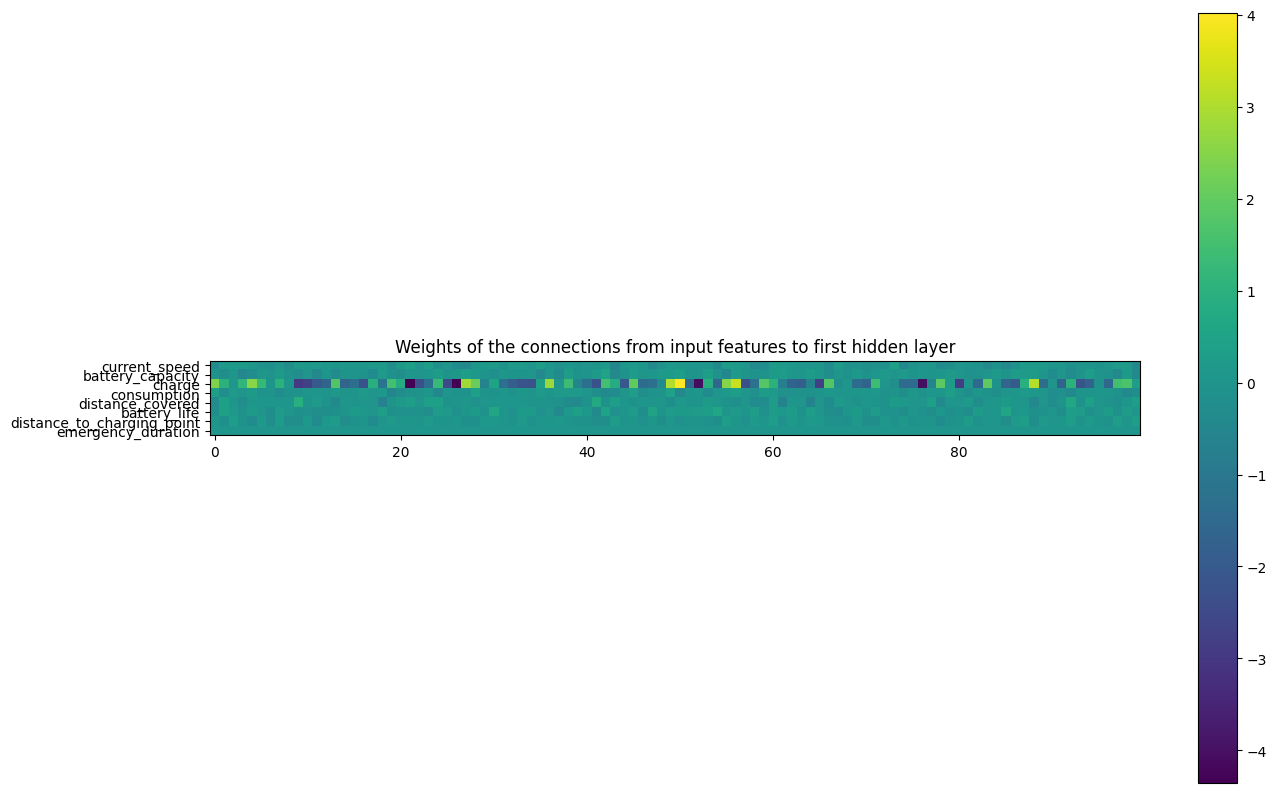

['drl_scaler_node4.pkl']

In [29]:
# Deep Reinforcement Learning Actor-Critic (DRL-AC)
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Initialize the model
model = MLPClassifier(max_iter=1000)

# Fit the model
model.fit(X_train_scaled, y_train_resampled)

# Make predictions
predictions = model.predict(X_train_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_train_resampled, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(y_train_resampled, predictions, zero_division=1)
print(report)

# Assuming model is your trained MLPClassifier
weights = model.coefs_[0]

# Visualizing weights using a heatmap
plt.figure(figsize=(15, 10))
plt.imshow(weights, interpolation='none', cmap='viridis')
plt.yticks(range(X_train_scaled.shape[1]), X.columns)
plt.colorbar()
plt.title('Weights of the connections from input features to first hidden layer')
plt.show()

# save the model
joblib.dump(model, 'drl_model_node4.pkl')
joblib.dump(scaler, 'drl_scaler_node4.pkl')

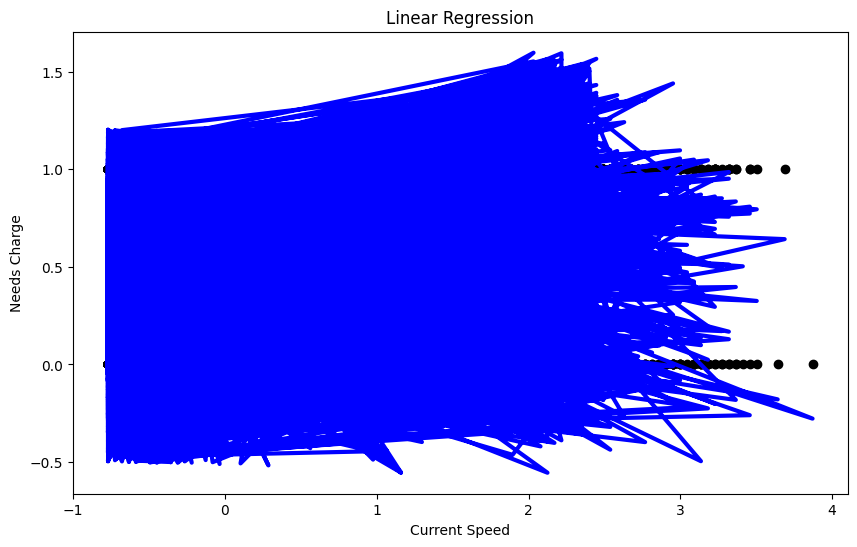

Accuracy: 0.95
              precision    recall  f1-score   support

        -1.0       0.00      1.00      0.00         0
         0.0       0.94      0.95      0.95      3480
         1.0       0.96      0.94      0.95      4101
         2.0       0.00      1.00      0.00         0

    accuracy                           0.95      7581
   macro avg       0.47      0.97      0.47      7581
weighted avg       0.95      0.95      0.95      7581



['linearReg_scaler_node4.pkl']

In [30]:
# Linear Regression
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X_train_scaled, y_train_resampled)

# visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_train_scaled[:, 0], y_train_resampled, color='black')
plt.plot(X_train_scaled[:, 0], model.predict(X_train_scaled), color='blue', linewidth=3)
plt.title('Linear Regression')
plt.xlabel('Current Speed')
plt.ylabel('Needs Charge')
plt.show()

# Make predictions
predictions = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions.round())

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(y_test, predictions.round(), zero_division=1)
print(report)

# save the model
joblib.dump(model, 'linearReg_model_node4.pkl')
joblib.dump(scaler, 'linearReg_scaler_node4.pkl')

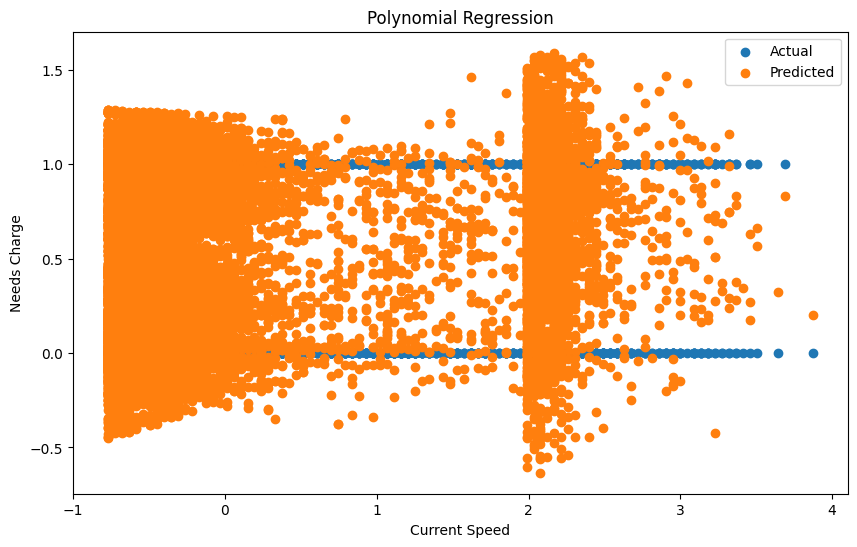

Accuracy: 0.94
              precision    recall  f1-score   support

        -1.0       0.00      1.00      0.00         0
         0.0       0.92      0.95      0.93      3480
         1.0       0.96      0.92      0.94      4101
         2.0       0.00      1.00      0.00         0

    accuracy                           0.94      7581
   macro avg       0.47      0.97      0.47      7581
weighted avg       0.94      0.94      0.94      7581



['polyReg_scaler_node4.pkl']

In [31]:

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Initialize the model
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
model = LinearRegression()

# Fit the model
model.fit(X_train_poly, y_train_resampled)

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_train_scaled[:, 0], y_train_resampled, label='Actual')
plt.scatter(X_train_scaled[:, 0], model.predict(X_train_poly), label='Predicted')
plt.title('Polynomial Regression')
plt.xlabel('Current Speed')
plt.ylabel('Needs Charge')
plt.legend()
plt.show()

# Make predictions
X_test_poly = poly.transform(X_test)
predictions = model.predict(X_test_poly)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions.round())

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(y_test, predictions.round(), zero_division=1)
print(report)

# save the model
joblib.dump(model, 'polyReg_model_node4.pkl')
joblib.dump(scaler, 'polyReg_scaler_node4.pkl')